In this notebook, we are going to fine-tune `SegFormerForSemanticSegmentation` on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [1]:
!pip install -q transformers datasets

     |████████████████████████████████| 4.7 MB 16.1 MB/s 
     |████████████████████████████████| 365 kB 51.7 MB/s 
     |████████████████████████████████| 101 kB 13.1 MB/s 
     |████████████████████████████████| 596 kB 72.9 MB/s 
     |████████████████████████████████| 6.6 MB 63.9 MB/s 
     |████████████████████████████████| 141 kB 71.0 MB/s 
     |████████████████████████████████| 212 kB 60.8 MB/s 
     |████████████████████████████████| 115 kB 67.9 MB/s 
     |████████████████████████████████| 127 kB 52.5 MB/s 


## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [2]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Note that this dataset is now also available on the hub :) you can directly check out the images [in your browser](scene_parse_150)! It can be easily loaded as follows (note that loading will take some time as the dataset is several GB's large):

In [3]:
from datasets import load_dataset

load_entire_dataset = False

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150")

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [4]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)
        
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))
        print(image)
        print(segmentation_map)

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the feature extractor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [5]:
from transformers import SegformerFeatureExtractor

root_dir = '/content/ADE20k_toy_dataset'
feature_extractor = SegformerFeatureExtractor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, train=False)

In [6]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


In [7]:
x = train_dataset[0]
# x

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=683x512 at 0x7F08BC0DC490>
<PIL.PngImagePlugin.PngImageFile image mode=L size=683x512 at 0x7F08BC058750>


Let's verify a random example:

In [8]:
encoded_inputs = train_dataset[0]

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=683x512 at 0x7F0938254AD0>
<PIL.PngImagePlugin.PngImageFile image mode=L size=683x512 at 0x7F08BC05FC10>


In [9]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [10]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

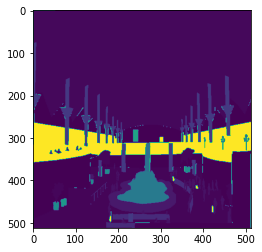

In [11]:
import matplotlib.pyplot as plt
plt.imshow(encoded_inputs["labels"])

In [12]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [13]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [15]:
batch = next(iter(train_dataloader))

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x251 at 0x7F08BBFACC50>
<PIL.PngImagePlugin.PngImageFile image mode=L size=384x251 at 0x7F08BBFACA10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x764 at 0x7F08BBFACC50>
<PIL.PngImagePlugin.PngImageFile image mode=L size=512x764 at 0x7F08BBFAC210>


In [16]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [17]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [18]:
mask = (batch["labels"] != 255)
mask

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]],

        [[False, False,  True,  ...,  True, False, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]]])

In [19]:
batch["labels"][mask]

tensor([2, 2, 2,  ..., 0, 0, 0])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [20]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import cached_download, hf_hub_url

# load id2label mapping from a JSON on the hub
repo_id = "datasets/huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename)), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150, 
                                                         id2label=id2label, 
                                                         label2id=label2id,
)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/file_download.py:563: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


Downloading:   0%|          | 0.00/2.81k [00:00<?, ?B/s]

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_fuse.weight', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear

## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [ ]:
# from datasets import list_metrics
# list_metrics()

In [ ]:
from datasets import load_metric

metric = load_metric("mean_iou")

In [ ]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
cur_loss = 10**18
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   tot_loss = 0.0
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        tot_loss += loss.detach().cpu().numpy()

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)
          
          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          metrics = metric.compute(num_labels=len(id2label), 
                                   ignore_index=255,
                                   reduce_labels=False, # we've already reduced the labels before)
          )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

   if tot_loss < cur_loss :
     cur_loss = tot_loss
     print("update best loss = ", cur_loss)
   else :
     print("epoch loss = ", tot_loss)



Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:258: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


Loss: 5.1021318435668945
Mean_iou: 0.0001329001881771653
Mean accuracy: 0.007242741116308873
update best loss =  25.255152225494385
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.910177707672119
Mean_iou: 0.0007460107048210228
Mean accuracy: 0.004337220053794135
update best loss =  24.40384817123413
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.8449249267578125
Mean_iou: 0.005111732558362288
Mean accuracy: 0.02566517085554742
update best loss =  23.72916269302368
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.783632278442383
Mean_iou: 0.014491385788674947
Mean accuracy: 0.0851935629644744
update best loss =  23.191017150878906
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.355532646179199
Mean_iou: 0.031903386746262676
Mean accuracy: 0.16395549286131259
update best loss =  22.334816932678223
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.195859909057617
Mean_iou: 0.043094085016390435
Mean accuracy: 0.22906755033834225
update best loss =  21.71980571746826
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.090053081512451
Mean_iou: 0.04989741144509487
Mean accuracy: 0.22792486566459097
update best loss =  20.531222820281982
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.037099361419678
Mean_iou: 0.07299398275342289
Mean accuracy: 0.2658682351923826
update best loss =  20.468805074691772
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.809796094894409
Mean_iou: 0.09102755097897747
Mean accuracy: 0.28548604369235475
update best loss =  19.589925050735474
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.7277488708496094
Mean_iou: 0.08712271701729411
Mean accuracy: 0.26729139393306584
update best loss =  19.411684036254883
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.583425521850586
Mean_iou: 0.1055096294918326
Mean accuracy: 0.2342158576915561
update best loss =  18.180400848388672
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.485919237136841
Mean_iou: 0.15026798436144218
Mean accuracy: 0.2878413925774212
update best loss =  17.85317087173462
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.63349986076355
Mean_iou: 0.11977903212573217
Mean accuracy: 0.24736070759097922
update best loss =  17.660909414291382
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.1088695526123047
Mean_iou: 0.18984103742594213
Mean accuracy: 0.2723145808154546
update best loss =  16.538723945617676
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.2436275482177734
Mean_iou: 0.20400605091329913
Mean accuracy: 0.27092236635746514
update best loss =  16.36231517791748
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.1640915870666504
Mean_iou: 0.22566764672995807
Mean accuracy: 0.3070805469187044
update best loss =  15.58082914352417
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.833556890487671
Mean_iou: 0.2347514195207775
Mean accuracy: 0.28254564036018864
update best loss =  15.234288930892944
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.080751657485962
Mean_iou: 0.18943953910570774
Mean accuracy: 0.2421867723579028
update best loss =  14.709628105163574
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.2204859256744385
Mean_iou: 0.20283574282920272
Mean accuracy: 0.274857600021869
epoch loss =  14.803634881973267
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.346498727798462
Mean_iou: 0.2232283815758592
Mean accuracy: 0.280158079101855
update best loss =  14.34389877319336
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.1979522705078125
Mean_iou: 0.23569395035615606
Mean accuracy: 0.279927855704084
epoch loss =  14.578974723815918
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6514761447906494
Mean_iou: 0.2292979039602587
Mean accuracy: 0.2747006134468478
update best loss =  13.730486869812012
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.8186469078063965
Mean_iou: 0.17524531664212636
Mean accuracy: 0.23337446196103556
update best loss =  12.765138745307922
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.7663052082061768
Mean_iou: 0.2617634118473959
Mean accuracy: 0.3324480370093478
epoch loss =  12.908397436141968
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6768362522125244
Mean_iou: 0.2390194343363645
Mean accuracy: 0.2890909181609479
update best loss =  12.091375589370728
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4656708240509033
Mean_iou: 0.27214491828664455
Mean accuracy: 0.3109645532363622
epoch loss =  12.157047629356384
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.755115270614624
Mean_iou: 0.25422960256406724
Mean accuracy: 0.3170074371047366
update best loss =  11.598452925682068
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4691524505615234
Mean_iou: 0.27182929327229666
Mean accuracy: 0.3304178968943597
epoch loss =  11.718000650405884
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9573606252670288
Mean_iou: 0.23846467127857252
Mean accuracy: 0.27438562477263273
update best loss =  10.725268959999084
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.194876194000244
Mean_iou: 0.24919111939217672
Mean accuracy: 0.29335532386384544
epoch loss =  10.893255591392517
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5354535579681396
Mean_iou: 0.27353890126723157
Mean accuracy: 0.3212541065711362
update best loss =  10.63537061214447
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6290099620819092
Mean_iou: 0.2866338930107052
Mean accuracy: 0.3277680702539436
update best loss =  10.534497261047363
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8442717790603638
Mean_iou: 0.26932332768202144
Mean accuracy: 0.3215030477218362
epoch loss =  10.542271375656128
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.067615270614624
Mean_iou: 0.22602948989194388
Mean accuracy: 0.28054381682486274
update best loss =  9.86558473110199
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.04761004447937
Mean_iou: 0.27407703749583057
Mean accuracy: 0.32626380436717534
update best loss =  9.321808218955994
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7177269458770752
Mean_iou: 0.35814176999040614
Mean accuracy: 0.4005384017336462
update best loss =  9.305760860443115
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.995358943939209
Mean_iou: 0.23999562346827813
Mean accuracy: 0.2949689647491269
epoch loss =  9.444510340690613
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9208426475524902
Mean_iou: 0.2730974326539613
Mean accuracy: 0.32679819276764394
update best loss =  8.742047309875488
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9912015199661255
Mean_iou: 0.2905714400752744
Mean accuracy: 0.3289662102700023
epoch loss =  8.799000263214111
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.391196608543396
Mean_iou: 0.35097442637842724
Mean accuracy: 0.40734141105142907
epoch loss =  8.754689574241638
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.67973792552948
Mean_iou: 0.29456064882748884
Mean accuracy: 0.34223959100695184
epoch loss =  8.794760584831238
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8636482954025269
Mean_iou: 0.3263749146351095
Mean accuracy: 0.3789928536193758
update best loss =  8.19559645652771
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6542600393295288
Mean_iou: 0.31492852088509193
Mean accuracy: 0.35542966193563486
epoch loss =  8.314116477966309
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3065935373306274
Mean_iou: 0.29699156381723085
Mean accuracy: 0.3310991565058818
update best loss =  8.087971091270447
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.691830039024353
Mean_iou: 0.31620232425487904
Mean accuracy: 0.3515708265424762
update best loss =  7.832379579544067
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7416034936904907
Mean_iou: 0.31649741124612757
Mean accuracy: 0.36310017202079864
update best loss =  7.5533835887908936
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.671576976776123
Mean_iou: 0.27152698021863786
Mean accuracy: 0.3115747944714065
epoch loss =  7.800561308860779
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8569672107696533
Mean_iou: 0.3138078593395198
Mean accuracy: 0.36583849654397343
epoch loss =  7.682997405529022
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.605056881904602
Mean_iou: 0.4676390980515937
Mean accuracy: 0.5169949352824695
update best loss =  7.312072575092316
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0038429498672485
Mean_iou: 0.2821491219193285
Mean accuracy: 0.3222602649707298
update best loss =  7.239952087402344
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4837253093719482
Mean_iou: 0.30499962471923653
Mean accuracy: 0.35480965298368944
epoch loss =  7.328195691108704
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6132023334503174
Mean_iou: 0.3092356896807085
Mean accuracy: 0.34773582695504
update best loss =  7.064425826072693
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7061457633972168
Mean_iou: 0.2893710462114911
Mean accuracy: 0.35006491055729433
epoch loss =  7.212977766990662
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3241525888442993
Mean_iou: 0.27197510547795994
Mean accuracy: 0.31494511101963757
update best loss =  6.476469695568085
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4383906126022339
Mean_iou: 0.3533229648480425
Mean accuracy: 0.39209940288504747
epoch loss =  6.816834807395935
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5443293452262878
Mean_iou: 0.3388376016423025
Mean accuracy: 0.37225839749712647
epoch loss =  6.5719775557518005
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1768176555633545
Mean_iou: 0.3244574873051936
Mean accuracy: 0.3636012542929448
epoch loss =  6.59173846244812
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0013446807861328
Mean_iou: 0.28728709494703664
Mean accuracy: 0.3307543674196583
update best loss =  6.362909436225891
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4922136068344116
Mean_iou: 0.3239870379094557
Mean accuracy: 0.37151348955492997
update best loss =  6.29068398475647
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3530867099761963
Mean_iou: 0.3662814447963598
Mean accuracy: 0.4173449374775353
epoch loss =  6.4154146909713745
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3738247156143188
Mean_iou: 0.31176832410766986
Mean accuracy: 0.35237733724354753
update best loss =  6.159933507442474
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1777044534683228
Mean_iou: 0.3526713951601254
Mean accuracy: 0.4009185069346998
update best loss =  5.588120996952057
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4784045219421387
Mean_iou: 0.3919057458560434
Mean accuracy: 0.4278791031307676
epoch loss =  5.882018029689789
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4577099084854126
Mean_iou: 0.3062365680949505
Mean accuracy: 0.3561880347666354
epoch loss =  6.132103145122528
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3068077564239502
Mean_iou: 0.499402123375014
Mean accuracy: 0.5461760268984257
update best loss =  5.432348370552063
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.26360285282135
Mean_iou: 0.33703024136405996
Mean accuracy: 0.3770054830369692
epoch loss =  5.610859811306
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5646888017654419
Mean_iou: 0.3018055245771953
Mean accuracy: 0.347553444633187
update best loss =  5.300401568412781
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.332464575767517
Mean_iou: 0.34430746051063826
Mean accuracy: 0.38750685573893257
update best loss =  5.031142890453339
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2735708951950073
Mean_iou: 0.41705330072290214
Mean accuracy: 0.45364077768590655
epoch loss =  5.070173978805542
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4723095893859863
Mean_iou: 0.3543317634484793
Mean accuracy: 0.3928848255324747
epoch loss =  5.32586544752121
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0170903205871582
Mean_iou: 0.39219275493647554
Mean accuracy: 0.4234415629012471
epoch loss =  5.353943198919296
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9750756621360779
Mean_iou: 0.39870448837977635
Mean accuracy: 0.4305634488258479
epoch loss =  5.059564292430878
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.784298837184906
Mean_iou: 0.43965750088639777
Mean accuracy: 0.48879797104364103
epoch loss =  5.090789437294006
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7400326728820801
Mean_iou: 0.3214765210837244
Mean accuracy: 0.36899954519547784
epoch loss =  5.116281509399414
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7649608254432678
Mean_iou: 0.3681900328128898
Mean accuracy: 0.4013217319396944
update best loss =  5.026235818862915
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1805499792099
Mean_iou: 0.38587453957194834
Mean accuracy: 0.43135843078815717
update best loss =  4.875439524650574
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9506111741065979
Mean_iou: 0.43121193036834005
Mean accuracy: 0.47050914999569
update best loss =  4.447620332241058
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0012304782867432
Mean_iou: 0.3695116168032703
Mean accuracy: 0.4143416419779022
epoch loss =  4.801203668117523
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.45821380615234375
Mean_iou: 0.3743769737808626
Mean accuracy: 0.41163446213177535
epoch loss =  4.51332288980484
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0353063344955444
Mean_iou: 0.374163662204078
Mean accuracy: 0.41341579146799334
epoch loss =  4.565983951091766
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0435551404953003
Mean_iou: 0.39906927453208796
Mean accuracy: 0.433515218536692
epoch loss =  4.818040609359741
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.157025694847107
Mean_iou: 0.29542782627369474
Mean accuracy: 0.35915528692756926
epoch loss =  4.61916720867157
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1348466873168945
Mean_iou: 0.38377747900588977
Mean accuracy: 0.41871600706936485
update best loss =  4.080454915761948
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.920401930809021
Mean_iou: 0.43203746215740435
Mean accuracy: 0.4617134878000166
epoch loss =  4.1090028285980225
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8866163492202759
Mean_iou: 0.4288690343177628
Mean accuracy: 0.45982044830585367
update best loss =  4.016864776611328
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8023337721824646
Mean_iou: 0.34257687803322706
Mean accuracy: 0.38108561414506964
epoch loss =  4.258086562156677
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4181002378463745
Mean_iou: 0.4863362487177021
Mean accuracy: 0.5252443571576985
epoch loss =  4.218143403530121
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5924026370048523
Mean_iou: 0.3868187501131827
Mean accuracy: 0.436216182361712
epoch loss =  4.0902416706085205
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8820354342460632
Mean_iou: 0.429004908036767
Mean accuracy: 0.46099716978284727
epoch loss =  4.406375706195831
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8136522173881531
Mean_iou: 0.4076688825727656
Mean accuracy: 0.4393812812003171
epoch loss =  4.696142703294754
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9815245866775513
Mean_iou: 0.34399365278327526
Mean accuracy: 0.37582903632035114
update best loss =  3.800357908010483
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.808095395565033
Mean_iou: 0.5068321662862713
Mean accuracy: 0.5480797640142155
epoch loss =  4.066983342170715
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.733235776424408
Mean_iou: 0.3698169150759851
Mean accuracy: 0.4092132135639032
epoch loss =  3.8682514429092407
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9848060011863708
Mean_iou: 0.3950236124690805
Mean accuracy: 0.44161896621978824
epoch loss =  4.064583957195282
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6439324021339417
Mean_iou: 0.4452714374807451
Mean accuracy: 0.4826891187925092
epoch loss =  3.9704062044620514
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8444150686264038
Mean_iou: 0.38754313441542215
Mean accuracy: 0.4233592845467369
epoch loss =  3.8398353457450867
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4107159674167633
Mean_iou: 0.43370539587898227
Mean accuracy: 0.47986228894788246
update best loss =  3.483739584684372
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49896857142448425
Mean_iou: 0.4317318222013999
Mean accuracy: 0.47062347367484864
update best loss =  3.438579559326172
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1147072315216064
Mean_iou: 0.42264533632980067
Mean accuracy: 0.466538527439315
epoch loss =  4.097022294998169
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5610212683677673
Mean_iou: 0.4505807881134688
Mean accuracy: 0.495070721806564
epoch loss =  3.6961565613746643
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.957878589630127
Mean_iou: 0.36703548202668895
Mean accuracy: 0.4137852022711627
epoch loss =  3.7200995087623596
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8629754185676575
Mean_iou: 0.443009661106542
Mean accuracy: 0.4678340734225262
epoch loss =  3.6665516197681427
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.868638277053833
Mean_iou: 0.36651823054731014
Mean accuracy: 0.42898027243846437
epoch loss =  3.56576606631279
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24985100328922272
Mean_iou: 0.5274526643638685
Mean accuracy: 0.5661772056602803
update best loss =  3.138534799218178
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8436585664749146
Mean_iou: 0.4196325725779408
Mean accuracy: 0.4552560673875408
epoch loss =  3.227082669734955
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7025810480117798
Mean_iou: 0.4522415311450607
Mean accuracy: 0.48335518405320865
epoch loss =  3.21506530046463
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7341035008430481
Mean_iou: 0.41592399349452613
Mean accuracy: 0.45270915554992497
update best loss =  3.0214710533618927
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3316301107406616
Mean_iou: 0.5196487426345779
Mean accuracy: 0.5505452835574436
epoch loss =  3.0774024724960327
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6711957454681396
Mean_iou: 0.4265763346340368
Mean accuracy: 0.4594263911021219
epoch loss =  3.558911696076393
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9405223727226257
Mean_iou: 0.4012855761581492
Mean accuracy: 0.44158036477991885
epoch loss =  3.1134463995695114
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6435624957084656
Mean_iou: 0.461374011090983
Mean accuracy: 0.4978575216475769
epoch loss =  3.40417218208313
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6720286011695862
Mean_iou: 0.4625447343745062
Mean accuracy: 0.4987356887305393
epoch loss =  3.2445952892303467
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.25320693850517273
Mean_iou: 0.45525806810202685
Mean accuracy: 0.5029456842431895
epoch loss =  3.336788058280945
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4845499098300934
Mean_iou: 0.4054533086740498
Mean accuracy: 0.44167462525867635
epoch loss =  3.2188408374786377
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6018874645233154
Mean_iou: 0.3879171272797158
Mean accuracy: 0.42694346154692425
update best loss =  2.7086983621120453
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6303205490112305
Mean_iou: 0.43389225398309067
Mean accuracy: 0.4626145474077482
epoch loss =  3.3829249441623688
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.46114328503608704
Mean_iou: 0.438026124093174
Mean accuracy: 0.4710044454852698
epoch loss =  2.9389720261096954
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6761597394943237
Mean_iou: 0.4237336581009021
Mean accuracy: 0.46581496549689494
epoch loss =  2.8462406992912292
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5599218010902405
Mean_iou: 0.5329010523681985
Mean accuracy: 0.5710719106455382
update best loss =  2.5726616382598877
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5973048806190491
Mean_iou: 0.40274324894767627
Mean accuracy: 0.4408167194231075
epoch loss =  2.9317722022533417
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5640348196029663
Mean_iou: 0.5095742265901149
Mean accuracy: 0.5439134958497327
epoch loss =  2.8035651445388794
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2803797423839569
Mean_iou: 0.4094403858013182
Mean accuracy: 0.44752408706944025
epoch loss =  2.730884402990341
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5746320486068726
Mean_iou: 0.4403833728449546
Mean accuracy: 0.4880569145557526
epoch loss =  2.7723288834095
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6792664527893066
Mean_iou: 0.45332125895016046
Mean accuracy: 0.4968969945410062
epoch loss =  2.629657953977585
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7393792271614075
Mean_iou: 0.46148495376494225
Mean accuracy: 0.49261321360453875
epoch loss =  2.6774058043956757
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.44137701392173767
Mean_iou: 0.5585497165629871
Mean accuracy: 0.5918973814162599
update best loss =  2.4271684288978577
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6079843044281006
Mean_iou: 0.42359528916139105
Mean accuracy: 0.4613985128132996
epoch loss =  2.574355274438858
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.702029824256897
Mean_iou: 0.5160665195262895
Mean accuracy: 0.5510618194540298
epoch loss =  2.529751271009445
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3812633454799652
Mean_iou: 0.4670704335873725
Mean accuracy: 0.49482013527702956
epoch loss =  2.5533607006073
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5188235640525818
Mean_iou: 0.46897006178797485
Mean accuracy: 0.5114520951829024
update best loss =  2.3404795825481415
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.47458434104919434
Mean_iou: 0.49995191873774786
Mean accuracy: 0.5397332077841509
epoch loss =  2.8352071344852448
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3180893063545227
Mean_iou: 0.39560968100190325
Mean accuracy: 0.4431971442576034
epoch loss =  2.692912995815277
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.51236891746521
Mean_iou: 0.4757746102205002
Mean accuracy: 0.5077916481012642
epoch loss =  2.592948317527771
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5452192425727844
Mean_iou: 0.45300902983613633
Mean accuracy: 0.5201342130245141
epoch loss =  2.4704819321632385
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.543742299079895
Mean_iou: 0.47716242927527924
Mean accuracy: 0.5236195436818291
epoch loss =  2.7253561913967133
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3939517140388489
Mean_iou: 0.5300906071235816
Mean accuracy: 0.571482398929769
update best loss =  2.3204659819602966
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6031041145324707
Mean_iou: 0.44790673623437854
Mean accuracy: 0.489667632657989
epoch loss =  2.4621609151363373
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5094831585884094
Mean_iou: 0.48199965291191066
Mean accuracy: 0.5143170147727533
update best loss =  2.147450178861618
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3655003607273102
Mean_iou: 0.508330883354261
Mean accuracy: 0.547432868915769
epoch loss =  2.632137507200241
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6337372660636902
Mean_iou: 0.4567493316212867
Mean accuracy: 0.50232448135005
epoch loss =  2.464415967464447
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8388030529022217
Mean_iou: 0.5117789749408034
Mean accuracy: 0.5398659995250815
epoch loss =  2.3507842421531677
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.18768413364887238
Mean_iou: 0.6033638349723563
Mean accuracy: 0.6728837520919635
epoch loss =  2.1816075295209885
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.44263774156570435
Mean_iou: 0.48567731064332603
Mean accuracy: 0.5241838895546306
epoch loss =  2.3678658604621887
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4490121006965637
Mean_iou: 0.3998984138146034
Mean accuracy: 0.43990876100037574
epoch loss =  2.171772688627243
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6500672698020935
Mean_iou: 0.507499373072653
Mean accuracy: 0.5431598478301218
epoch loss =  2.3253390043973923
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5355474352836609
Mean_iou: 0.5151051084408458
Mean accuracy: 0.5692408139238437
epoch loss =  2.6802178025245667
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5019317269325256
Mean_iou: 0.4599281623555218
Mean accuracy: 0.492678950000557
epoch loss =  2.205382764339447
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.26441213488578796
Mean_iou: 0.5330760543251521
Mean accuracy: 0.5641338055356109
epoch loss =  2.2281189560890198
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.45300328731536865
Mean_iou: 0.4902255034281911
Mean accuracy: 0.5192536836168322
update best loss =  2.104491740465164
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.41471952199935913
Mean_iou: 0.44303665991115
Mean accuracy: 0.48575468404984107
epoch loss =  2.2287210673093796
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3939918875694275
Mean_iou: 0.5053156063395736
Mean accuracy: 0.534661898001472
update best loss =  2.0143379867076874
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.46373364329338074
Mean_iou: 0.503980956686716
Mean accuracy: 0.5493076419633485
epoch loss =  2.152353674173355
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.44654443860054016
Mean_iou: 0.46754041959640874
Mean accuracy: 0.5061261173742901
epoch loss =  2.210662305355072
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.393125057220459
Mean_iou: 0.5651762550551019
Mean accuracy: 0.6004035481371329
epoch loss =  2.098784774541855
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5238077044487
Mean_iou: 0.5160041523964913
Mean accuracy: 0.5564523293186487
epoch loss =  2.2583569288253784
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.477095365524292
Mean_iou: 0.5340357589982233
Mean accuracy: 0.5719426397677102
update best loss =  1.8393511027097702
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3840934634208679
Mean_iou: 0.5391259518518697
Mean accuracy: 0.5655587883526688
epoch loss =  1.9440338909626007
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.583098292350769
Mean_iou: 0.5118791088168507
Mean accuracy: 0.541319550822768
epoch loss =  2.0875555276870728
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22681236267089844
Mean_iou: 0.43837714217041496
Mean accuracy: 0.4894113032294981
epoch loss =  2.1459023356437683
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.44714775681495667
Mean_iou: 0.5255541438783703
Mean accuracy: 0.560446488157743
epoch loss =  1.9882052540779114
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.25986164808273315
Mean_iou: 0.5028543948687619
Mean accuracy: 0.5538127465318868
epoch loss =  2.1347943246364594
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3814188539981842
Mean_iou: 0.5133806962374671
Mean accuracy: 0.5462843715412201
epoch loss =  2.124779134988785
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.41579610109329224
Mean_iou: 0.4879564653294004
Mean accuracy: 0.5247384488441773
epoch loss =  2.0098514407873154
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.542625904083252
Mean_iou: 0.5041041822298303
Mean accuracy: 0.5353257722359078
epoch loss =  1.9932405352592468
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.33312761783599854
Mean_iou: 0.5326185552232987
Mean accuracy: 0.5621989096995229
update best loss =  1.798300489783287
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.33201315999031067
Mean_iou: 0.5304841012716865
Mean accuracy: 0.5825976797938357
epoch loss =  1.8772237300872803
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.34596899151802063
Mean_iou: 0.46144667423714364
Mean accuracy: 0.5016943514730946
update best loss =  1.7882819026708603
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.46561357378959656
Mean_iou: 0.4770789067431513
Mean accuracy: 0.5187771356832082
epoch loss =  1.8930529952049255
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.27156075835227966
Mean_iou: 0.5798934419092405
Mean accuracy: 0.623194946430016
update best loss =  1.7268627882003784
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3847575783729553
Mean_iou: 0.5427173164348281
Mean accuracy: 0.5761984874189597
epoch loss =  2.185446858406067
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.43328386545181274
Mean_iou: 0.4285665321709464
Mean accuracy: 0.4985613977905928
epoch loss =  1.8270498514175415
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24152690172195435
Mean_iou: 0.613041430388191
Mean accuracy: 0.6481033256994864
epoch loss =  1.7316448390483856
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23190267384052277
Mean_iou: 0.5567771639631893
Mean accuracy: 0.5953462246308383
epoch loss =  1.7506322711706161
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.35573694109916687
Mean_iou: 0.4748846340623956
Mean accuracy: 0.5342543575398674
update best loss =  1.6978683918714523
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2902814447879791
Mean_iou: 0.5374163064799393
Mean accuracy: 0.581526552456583
update best loss =  1.5980032533407211
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2449529618024826
Mean_iou: 0.5834563799077106
Mean accuracy: 0.6071627937348325
update best loss =  1.5789506882429123
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3766595721244812
Mean_iou: 0.49445910994406433
Mean accuracy: 0.5356762713500229
epoch loss =  1.5974429547786713
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.42253559827804565
Mean_iou: 0.634365979495717
Mean accuracy: 0.6702498597308532
epoch loss =  1.6658556833863258
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.41668272018432617
Mean_iou: 0.564059118807415
Mean accuracy: 0.588435847137236
epoch loss =  1.6446069031953812
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.47174271941185
Mean_iou: 0.4989766760596896
Mean accuracy: 0.5689999822073585
epoch loss =  1.6134676188230515
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3932932913303375
Mean_iou: 0.5731109730048084
Mean accuracy: 0.6145295431310048
epoch loss =  1.7437527179718018
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37759163975715637
Mean_iou: 0.52371355625082
Mean accuracy: 0.5540113973036224
update best loss =  1.5441692471504211
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4458516538143158
Mean_iou: 0.4941396444030874
Mean accuracy: 0.5316141489248636
update best loss =  1.5370936840772629
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36409416794776917
Mean_iou: 0.6510887852877526
Mean accuracy: 0.689630733332541
epoch loss =  1.8852041065692902
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2359320968389511
Mean_iou: 0.4686943742627447
Mean accuracy: 0.5206913496560265
epoch loss =  1.5418783724308014
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16050875186920166
Mean_iou: 0.5596023558475851
Mean accuracy: 0.5895844214252213
epoch loss =  1.6197530031204224
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3295550048351288
Mean_iou: 0.5506598602712388
Mean accuracy: 0.5929212759998304
epoch loss =  1.6498108357191086
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29578897356987
Mean_iou: 0.6446139898896949
Mean accuracy: 0.6794164545983412
update best loss =  1.458835944533348
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4647843837738037
Mean_iou: 0.48781011843913347
Mean accuracy: 0.5251186619960051
epoch loss =  1.4839060753583908
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4174962043762207
Mean_iou: 0.5663529467687065
Mean accuracy: 0.5944255901196699
update best loss =  1.44768875092268
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22074449062347412
Mean_iou: 0.6504025808155748
Mean accuracy: 0.7057771457024085
epoch loss =  1.7751003205776215
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.41880813241004944
Mean_iou: 0.5265898515064368
Mean accuracy: 0.5577730972540446
update best loss =  1.404668167233467
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23180407285690308
Mean_iou: 0.498909007279089
Mean accuracy: 0.559370750203864
epoch loss =  1.5251320600509644
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36698514223098755
Mean_iou: 0.5712733045214404
Mean accuracy: 0.6127105539314082
epoch loss =  1.6032607406377792
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12792016565799713
Mean_iou: 0.5953781912164233
Mean accuracy: 0.623436715379766
update best loss =  1.3781873434782028
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37058258056640625
Mean_iou: 0.5303553025554097
Mean accuracy: 0.581609822707481
update best loss =  1.3488227427005768
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.40197810530662537
Mean_iou: 0.5577404551957281
Mean accuracy: 0.585991012458792
epoch loss =  1.438885435461998
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.14888042211532593
Mean_iou: 0.584170717243981
Mean accuracy: 0.6281011354666858
epoch loss =  1.4960260093212128
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.289867639541626
Mean_iou: 0.5756966203142231
Mean accuracy: 0.6106213896215666
epoch loss =  1.4285598993301392
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4487336575984955
Mean_iou: 0.5471645964158421
Mean accuracy: 0.5936691070554628
epoch loss =  1.5792126506567001


## Inference

Finally, let's check whether the model has really learned something. Let's test the trained model on an image:

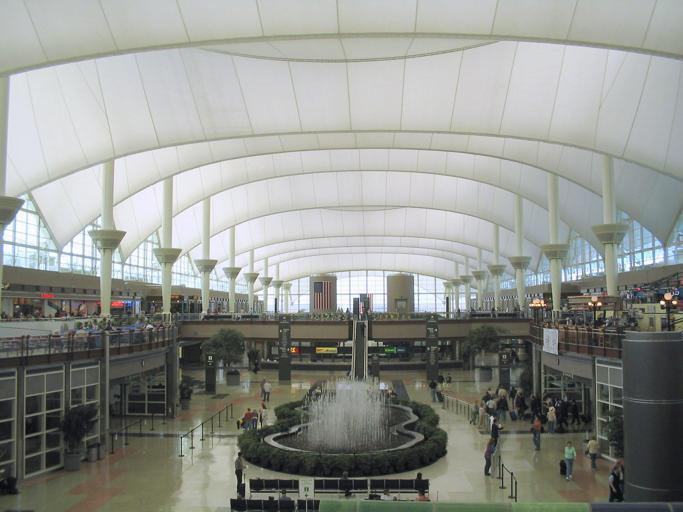

In [ ]:
image = Image.open('/content/ADE20k_toy_dataset/images/training/ADE_train_00000001.jpg')
image

In [ ]:
# prepare the image for the model
encoding = feature_extractor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [ ]:
# forward pass
outputs = model(pixel_values=pixel_values)

In [ ]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [ ]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

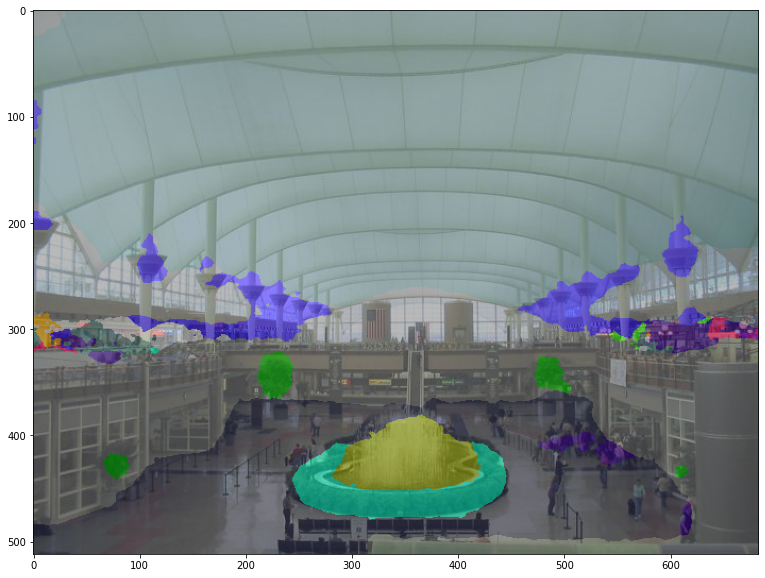

In [ ]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

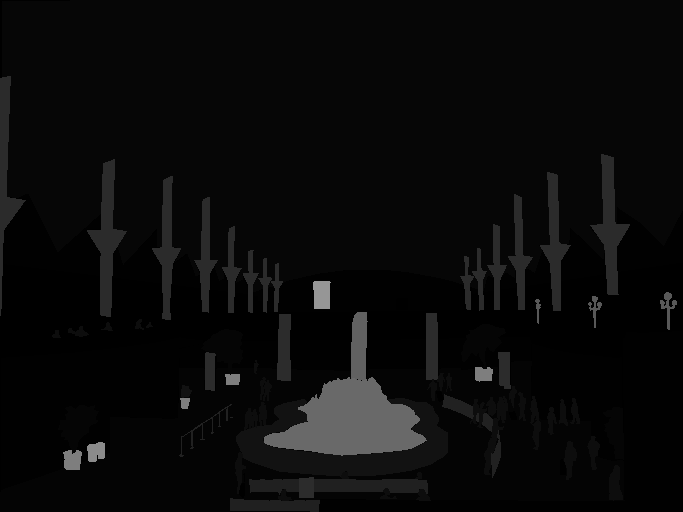

In [ ]:
map = Image.open('/content/ADE20k_toy_dataset/annotations/training/ADE_train_00000001.png') 
map 

Classes in this image: ['wall', 'floor', 'tree', 'ceiling', 'person', 'plant', 'seat', 'fence', 'column', 'signboard', 'streetlight', 'escalator', 'fountain', 'pot', 'ashcan', 'flag', None]


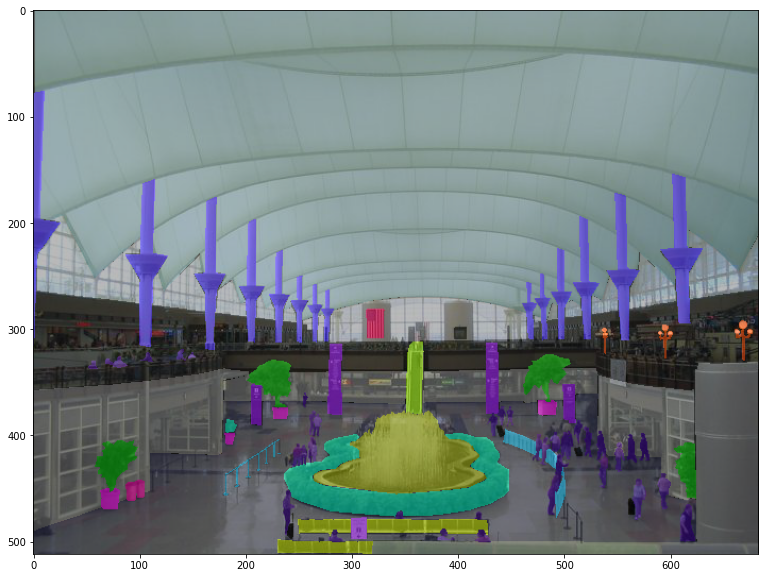

In [ ]:
# convert map to NumPy array
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [ ]:
seg.unique()

tensor([  0,   3,   4,   5,  12,  13,  14,  17,  22,  27,  37,  42,  58,  68,
        104, 119, 134, 145])

In [ ]:
model.config.id2label[37]

'bathtub'

In [ ]:
np.unique(map)

array([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104,
       125, 138, 149, 255], dtype=uint8)

In [ ]:
seg

tensor([[0, 0, 0,  ..., 5, 5, 5],
        [0, 0, 0,  ..., 5, 5, 5],
        [0, 0, 0,  ..., 5, 5, 5],
        ...,
        [3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0]])

In [ ]:
map

array([[255, 255, 255, ...,   5,   5,   5],
       [255, 255,   5, ...,   5,   5,   5],
       [255, 255,   5, ...,   5,   5,   5],
       ...,
       [  3,   3,   3, ...,   0,   0, 255],
       [  3,   3,   3, ...,   0,   0, 255],
       [  3,   3,   3, ...,   0,   0,   0]], dtype=uint8)

Let's compute the metrics:

In [ ]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric.compute(predictions=[seg.numpy()], references=[map], num_labels=150, ignore_index=255)

In [ ]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [ ]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.5043542375830968
mean_accuracy 0.5476225696460779
overall_accuracy 0.9467249652568372
---------------------
per-category metrics:


,IoU,accuracy
wall,0.914095,0.964186
building,NaN,NaN
sky,NaN,NaN
floor,0.931949,0.984126
tree,0.461409,0.495241
...,...,...
shower,0.975659,0.984982
radiator,NaN,NaN
glass,NaN,NaN
clock,0.000000,0.000000
